* best validation loss : 0.5262180339206349(img size=256, all fc to 1\*1 conv, nn.upsample)
  * 0.546918155930259(img size=224)
  * worse than above(no input normalization)
  * 0.5481791387904774(lower lr=5e-6)
* best validation loss : 0.4841527131470767(restructured fcn)
  * FCN16 : 0.46314543025060134

In [1]:
import os 

import torch
from torch import nn
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import vgg16, VGG16_Weights

from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

from torchsummary import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np

c:\Users\lijm1\anaconda3\envs\torch-light\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ToNumpy(object):
    def __call__(self, image):
        self.image = image
        self.image = np.array(self.image)
        return torch.tensor(self.image)
    
class NoVoid(object):
    def __call__(self, tensor):
        return torch.where(tensor==255, 0, tensor)
    
# class OneHot(object):
#     def __call__(self, tensor):
#         shape = tensor.shape
#         tensor = tensor.to(torch.int64)
#         # one hot : (B, C=num_classes, H, W)
#         one_hot = torch.zeros((shape[0], 21) + shape[1:])
        
#         # labels : (B, H, W)
#         # labels.unsqueeze(1) : (B, C=1, H, W)
#         # ret : (B, C=num_classes, H, W)
#         ret = one_hot.scatter_(1, tensor.unsqueeze(1), 1.0)
#         return ret.transpose(0, 1)



In [10]:
image_size = (256, 256)
transform1 = Compose([Resize(image_size), ToTensor(), Normalize(mean=[0.4538, 0.4416, 0.4077], std=[0.2631, 0.2597, 0.2765])])
transform2 = Compose([Resize(image_size), ToTensor(), Normalize(mean=[0.4563, 0.4381, 0.3995], std=[0.2614, 0.2595, 0.2757])])
target_transform = Compose([Resize(image_size),ToNumpy(), NoVoid()])

In [11]:
class_dict = {0:"background", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle", 6:"bus", 7:"car" , 8:"cat", 9:"chair", 10:"cow", 11:"diningtable", 12:"dog", 13:"horse", 14:"motorbike", 15:"person", 16:"potted plant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv/monitor"}

In [12]:
ds = VOCSegmentation("./data", year="2011", image_set="train", download=False, transform=transform1, target_transform=target_transform)
ds_val = VOCSegmentation("./data_val", year="2011", image_set="val", download=False, transform=transform2, target_transform=target_transform)

In [6]:
# def batch_mean_and_sd(loader):
    
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in loader:
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (
#                       cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (
#                             cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(
#       snd_moment - fst_moment ** 2)        
#     return mean,std

In [13]:
ds[0][0].shape

torch.Size([3, 256, 256])

In [14]:
ds[0][1].shape

torch.Size([256, 256])

In [15]:
fcn_vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

def new_forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.classifier(x)
    return x

bound_method = new_forward.__get__(fcn_vgg16, fcn_vgg16.__class__)
setattr(fcn_vgg16, 'forward', bound_method)

# fcn_vgg16.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))

fcn_vgg16.classifier = nn.Sequential(
    nn.Conv2d(512, 4096, (1, 1)),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(4096, 4096, (1, 1)),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(4096, 21, (1, 1)),
    nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)
    # nn.ConvTranspose2d(21, 21, (32, 32), stride=32, bias=False)
)

for name, module in fcn_vgg16.classifier.named_modules():
    if name == '6':
        module.weight.data.zero_()


In [16]:
class FCN16_vgg16(nn.Module):
    def __init__(self, dropout = 0.5):
        super().__init__()
        
        self.pool1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        
        self.pool2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.pool3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.pool4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        
        self.pool5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, (1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout, inplace=False),
            nn.Conv2d(4096, 4096, (1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout, inplace=False),
            nn.Conv2d(4096, 21, (1, 1)),
        )
        
        self.pool5_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.sum_upsample = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.pool3(x)
        x_pool4 = self.pool4(x)
        x_pool5 = self.pool5(x_pool4)
        
        x_pool4 = self.classifier(x_pool4)
        x_pool5 = self.classifier(x_pool5)
        
        x_pool5 = self.pool5_upsample(x_pool5)
        
        x = x_pool4 + x_pool5
        x = self.sum_upsample(x)
        
        return x

In [19]:
fcn16_vgg16 = FCN16_vgg16()

modulelist = [module for name, module in fcn16_vgg16.named_modules() if len(name.split('.')) == 2 and name.split('.')[0][:-1] == 'pool']
modulelist_tocopy = [module for name, module in fcn_vgg16.named_modules() if len(name.split('.')) == 2 and name.split('.')[0] == 'features']

for module, module_tocopy in zip(modulelist, modulelist_tocopy):
    if isinstance(module, nn.Conv2d):
        module.weight = nn.Parameter(module_tocopy.weight.clone())
        module.bias = nn.Parameter(module_tocopy.bias.clone())

In [22]:
for name, param in fcn16_vgg16.named_parameters():
    print(param)
    break

Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5.2149e-01,  9.8740

In [12]:
summary(fcn_vgg16, (3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [25]:
train_dataloader = DataLoader(ds, batch_size=20, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(ds_val, batch_size=20, shuffle=True, drop_last=True)

In [27]:
device = "cuda"
model = fcn16_vgg16.to(device)

In [29]:
train_losslist = []
val_losslist = []
# optimizer = SGD(fcn_vgg16.parameters(), 1e-4, momentum=0.9, weight_decay=5**-4)
optimizer = Adam(model.parameters(), lr=1e-5)
epochs = 200
loss = nn.CrossEntropyLoss()

patience = 10
earlystop_counter = 0
best_loss = np.inf

epoch_start = 1

# checkpoint = torch.load('saved/checkpoint_model_14.pt')
# epoch_start = checkpoint['epoch']
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# train_losslist = checkpoint['train_loss']
# val_losslist = checkpoint['val_loss']
# best_loss = checkpoint['earlystop']['bestloss']

for i in range(epoch_start, epochs+1):
    print("-----------------------------")
    print(f"epoch {i}")
    model.train()
    loss_sum = 0
    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
        X = X.to(device)
        y = y.to(device).long()
        pred = model(X)
        loss_out = loss(pred, y)
        
        optimizer.zero_grad()
        loss_out.backward()
        optimizer.step()
        loss_sum += loss_out.item()
    train_losslist.append(loss_sum/len(train_dataloader))
    print(f"total loss : {loss_sum/len(train_dataloader)}")
    
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(valid_dataloader)):
            X = X.to(device)
            y = y.to(device).long()
            pred = model(X)
            loss_sum += loss(pred, y).item()
        val_loss = loss_sum/len(valid_dataloader)
        val_losslist.append(val_loss)
        print(f"val loss : {val_loss}")
        
        if best_loss > val_loss:
            print(f"validation loss imporved : {best_loss} -> {val_loss}")
            best_loss = val_loss
            earlystop_counter = 0
            torch.save(model.state_dict(), "best.pt")
        else:
            earlystop_counter+=1
        
        if earlystop_counter == patience:
            print(f"No validation improvement until {earlystop_counter} epoch. Terminating training loop.")
            best = torch.load("best.pt")
            model.load_state_dict(best)
            break
        
    torch.save({
        'epoch': i,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losslist,
        'val_loss': val_losslist,
        'earlystop': {'patience': patience, 'counter': earlystop_counter, 'bestloss': best_loss}
    }, os.path.normpath(f"saved/checkpoint_model_{i}.pt"))
    
    try:
        os.remove(os.path.normpath(f"saved/checkpoint_model_{i-1}.pt"))
    except OSError:
        pass

    print("")
            
            
        

-----------------------------
epoch 1


100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


total loss : 1.4671430706977844


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


val loss : 1.0789119254459034
validation loss imporved : inf -> 1.0789119254459034

-----------------------------
epoch 2


100%|██████████| 55/55 [01:27<00:00,  1.60s/it]


total loss : 0.9878287358717485


100%|██████████| 55/55 [00:34<00:00,  1.58it/s]


val loss : 0.9494284879077565
validation loss imporved : 1.0789119254459034 -> 0.9494284879077565

-----------------------------
epoch 3


100%|██████████| 55/55 [01:13<00:00,  1.33s/it]


total loss : 0.8757041562687267


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


val loss : 0.8372458306225863
validation loss imporved : 0.9494284879077565 -> 0.8372458306225863

-----------------------------
epoch 4


100%|██████████| 55/55 [01:32<00:00,  1.68s/it]


total loss : 0.766588282585144


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


val loss : 0.7457579742778432
validation loss imporved : 0.8372458306225863 -> 0.7457579742778432

-----------------------------
epoch 5


100%|██████████| 55/55 [01:24<00:00,  1.54s/it]


total loss : 0.6683115747841921


100%|██████████| 55/55 [00:46<00:00,  1.19it/s]


val loss : 0.6737028002738953
validation loss imporved : 0.7457579742778432 -> 0.6737028002738953

-----------------------------
epoch 6


100%|██████████| 55/55 [01:46<00:00,  1.93s/it]


total loss : 0.5782336034558037


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


val loss : 0.5904953663999384
validation loss imporved : 0.6737028002738953 -> 0.5904953663999384

-----------------------------
epoch 7


100%|██████████| 55/55 [01:50<00:00,  2.01s/it]


total loss : 0.5111847048456019


100%|██████████| 55/55 [00:41<00:00,  1.33it/s]


val loss : 0.5399810487573797
validation loss imporved : 0.5904953663999384 -> 0.5399810487573797

-----------------------------
epoch 8


100%|██████████| 55/55 [01:42<00:00,  1.87s/it]


total loss : 0.4554811412637884


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


val loss : 0.5130917381156574
validation loss imporved : 0.5399810487573797 -> 0.5130917381156574

-----------------------------
epoch 9


100%|██████████| 55/55 [01:17<00:00,  1.41s/it]


total loss : 0.41879724264144896


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


val loss : 0.5178640831600536

-----------------------------
epoch 10


100%|██████████| 55/55 [01:26<00:00,  1.57s/it]


total loss : 0.3852000317790292


100%|██████████| 55/55 [00:37<00:00,  1.48it/s]


val loss : 0.4859779130328785
validation loss imporved : 0.5130917381156574 -> 0.4859779130328785

-----------------------------
epoch 11


100%|██████████| 55/55 [01:52<00:00,  2.05s/it]


total loss : 0.3553873070261695


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


val loss : 0.47629308917305685
validation loss imporved : 0.4859779130328785 -> 0.47629308917305685

-----------------------------
epoch 12


100%|██████████| 55/55 [02:47<00:00,  3.04s/it]


total loss : 0.3298510727557269


100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


val loss : 0.49171595735983414

-----------------------------
epoch 13


100%|██████████| 55/55 [02:32<00:00,  2.78s/it]


total loss : 0.3089291878721931


100%|██████████| 55/55 [01:07<00:00,  1.23s/it]


val loss : 0.4756882001053203
validation loss imporved : 0.47629308917305685 -> 0.4756882001053203

-----------------------------
epoch 14


100%|██████████| 55/55 [02:37<00:00,  2.86s/it]


total loss : 0.288223504207351


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


val loss : 0.474303694746711
validation loss imporved : 0.4756882001053203 -> 0.474303694746711

-----------------------------
epoch 15


100%|██████████| 55/55 [01:51<00:00,  2.02s/it]


total loss : 0.2739409227262844


100%|██████████| 55/55 [00:46<00:00,  1.18it/s]


val loss : 0.4739743243564259
validation loss imporved : 0.474303694746711 -> 0.4739743243564259

-----------------------------
epoch 16


100%|██████████| 55/55 [01:20<00:00,  1.47s/it]


total loss : 0.25786320865154266


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


val loss : 0.4743467775258151

-----------------------------
epoch 17


100%|██████████| 55/55 [00:55<00:00,  1.02s/it]


total loss : 0.24416947310621087


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


val loss : 0.4693040918220173
validation loss imporved : 0.4739743243564259 -> 0.4693040918220173

-----------------------------
epoch 18


100%|██████████| 55/55 [01:18<00:00,  1.43s/it]


total loss : 0.2313774737444791


100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


val loss : 0.4926248203624379

-----------------------------
epoch 19


100%|██████████| 55/55 [01:19<00:00,  1.45s/it]


total loss : 0.22067561854015696


100%|██████████| 55/55 [00:41<00:00,  1.34it/s]


val loss : 0.4755637827244672

-----------------------------
epoch 20


100%|██████████| 55/55 [01:14<00:00,  1.35s/it]


total loss : 0.21257924816825174


100%|██████████| 55/55 [00:35<00:00,  1.54it/s]


val loss : 0.4715064379301938

-----------------------------
epoch 21


100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


total loss : 0.2034861591729251


100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


val loss : 0.4769870966672897

-----------------------------
epoch 22


100%|██████████| 55/55 [01:38<00:00,  1.80s/it]


total loss : 0.1943056721578945


100%|██████████| 55/55 [00:50<00:00,  1.09it/s]


val loss : 0.48322191400961445

-----------------------------
epoch 23


100%|██████████| 55/55 [01:43<00:00,  1.88s/it]


total loss : 0.1859806869517673


100%|██████████| 55/55 [01:10<00:00,  1.27s/it]


val loss : 0.4888436127792705

-----------------------------
epoch 24


100%|██████████| 55/55 [01:17<00:00,  1.40s/it]


total loss : 0.18022165298461915


100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


val loss : 0.4902465771545063

-----------------------------
epoch 25


100%|██████████| 55/55 [01:55<00:00,  2.10s/it]


total loss : 0.17404232201251116


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


val loss : 0.4940821132876656

-----------------------------
epoch 26


100%|██████████| 55/55 [01:27<00:00,  1.58s/it]


total loss : 0.16812735023823652


100%|██████████| 55/55 [00:41<00:00,  1.34it/s]


val loss : 0.489797845211896

-----------------------------
epoch 27


100%|██████████| 55/55 [01:44<00:00,  1.91s/it]


total loss : 0.16480441797863354


100%|██████████| 55/55 [00:38<00:00,  1.44it/s]

val loss : 0.49363876472819934
No validation improvement until 10 epoch. Terminating training loop.


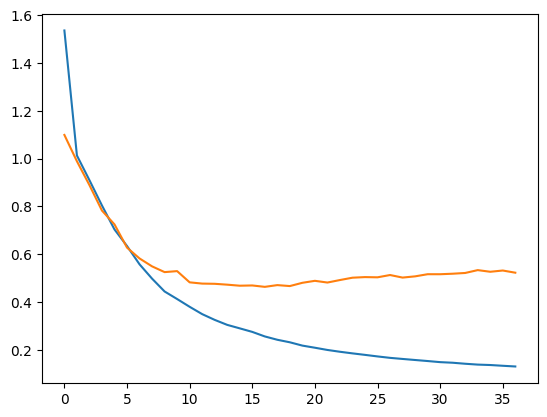

In [16]:
plt.plot(train_losslist)
plt.plot(val_losslist)

In [23]:
# checkpoint = torch.load("best.pt")
# fcn16_vgg16.load_state_dict(checkpoint)

In [27]:
# fcn_vgg16.load_state_dict(checkpoint)

In [17]:
mask_cmap = [
"#800080",
"#0F0F0F",
"#FF0000",
"#00FF00",
"#0000FF",
"#FFFF00",
"#00FFFF",
"#FF00FF",
"#FFA500",
"#A52A2A",
"#00FF7F",
"#FFC0CB",
"#008080",
"#E6E6FA",
"#800000",
"#808000",
"#FF7F50",
"#000080",
"#808080",
"#87CEEB",
"#F5F5DC"]

In [18]:
from matplotlib.colors import ListedColormap

In [19]:
cm = ListedColormap(mask_cmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


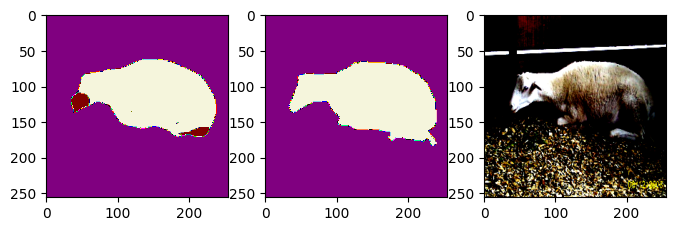

In [29]:
image_idx = 20
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
axes = axes.flatten()

output = model(ds_val[image_idx][0].unsqueeze(dim=0).to(device))

ax1 = axes[0].imshow(output[0].argmax(axis=0).cpu(), cmap=cm)
ax2 = axes[1].imshow(ds_val[image_idx][1], cmap=cm)
ax3 = axes[2].imshow(ds_val[image_idx][0].permute(1, 2, 0))

plt.show()